# Plan
1. Get stops from bustime (function)
2. Get road graph from bustime (function)
3. Clip telemetry (function)
4. Identify paths: order by time, window func split (session identifying algorithm) over stop flag (function)
5. Check the result and distributuion of parameters (adhoc)
6. Aggregate into paths (origin, target, time, length)

# Point 1

In [132]:
import time
import yaml
import requests
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon, LineString, Point
from sqlalchemy import create_engine
from json import JSONDecodeError

In [2]:
def get_stops(city):
    """
    Returns df of bus stops from Overpass API
    """
    
    query = f"""
    [out:json];

    area
      ["name:en"="{city}"];

    node
      [highway=bus_stop]
      (area);
    out body qt;
    """
    
    response = requests.get("http://overpass-api.de/api/interpreter",
                             params={'data': query.encode('utf-8')})
    
    df = pd.DataFrame(response.json()['elements'])
    df['geometry'] = gpd.GeoSeries.from_xy(x=df['lon'], y=df['lat'])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    return gdf

In [3]:
done_flag = False
while not done_flag:
    try:
        stops_raw_gdf = get_stops('Kazan')
        done_flag = True
    except JSONDecodeError:
        pass

In [4]:
def get_tags(data_raw, tags):
    """
    Returns normalized data from tags column
    """
    
    data = data_raw.copy()
    normalized = pd.json_normalize(data['tags'])
    
    data = data.join(normalized, how='left', rsuffix='_tag')
    
    data = data.drop(columns=['tags',
        *[column for column in normalized.columns if column not in tags]
    ])
    
    return data

In [5]:
stops_gdf = get_tags(stops_raw_gdf, [
    'name',
])

In [152]:
stops_gdf.head()

,type,id,lat,lon,geometry,name
0,node,1003659755,55.701521,49.067645,POINT (49.06765 55.70152),пос.Старое Победилово
1,node,1003659977,55.701288,49.067506,POINT (49.06751 55.70129),пос.Старое Победилово
2,node,5525767937,55.800625,48.969316,POINT (48.96932 55.80063),жилой массив Старое Аракчино
3,node,5525767935,55.800022,48.977831,POINT (48.97783 55.80002),Переправа
4,node,5525767936,55.800388,48.977375,POINT (48.97738 55.80039),Переправа


<AxesSubplot:>

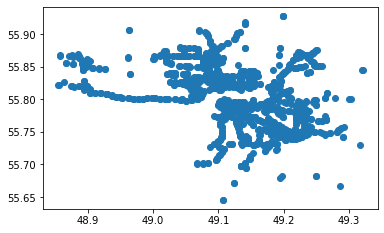

In [6]:
stops_gdf.plot()

# Point 2

In [7]:
def list_to_wkt(list_):
    list_ = [' '.join([str(coordinate) for coordinate in node]) for node in list_]
    wkt_string = 'LINESTRING ('+','.join(list_) + ')'
    return wkt_string

In [8]:
def get_roads(city, clip=True):
    """
    Returns df with road graph
    """
    
    nodes_query = f"""
    [out:json];
    area
      ["name:en"="{city}"];
    ( 
      node(area);
    );
    out body;
    >;
    out skel qt;
    """
    
    ways_query = f"""
    [out:json];
    area
      ["name:en"="{city}"];
    ( 
      way["highway"](area);
    );
    out body;
    >;
    out skel qt;
    """
    
    nodes_json = requests.get("http://overpass-api.de/api/interpreter",
                               params={'data': nodes_query.encode('utf-8')}).json()
    
    nodes_dict = {node['id']: [node['lon'], node['lat']] for node in nodes_json['elements']}
    
    time.sleep(10)
    
    ways_json = requests.get("http://overpass-api.de/api/interpreter",
                              params={'data': ways_query.encode('utf-8')}).json()
    
    for way in ways_json['elements']:
        if way.get('tags') is None:
            way['tags'] = {}
    
    ways_list = [{
        'id': way['id'],
        'nodes': way.get('nodes'),
        'name': way.get('tags').get('name'),
        'ref': way.get('tags').get('ref'),
        'highway': way.get('tags').get('highway'),
        'destination:ref': way.get('tags').get('destination:ref')
    } for way in ways_json['elements']]
    
    for way in ways_list:
        if way.get('nodes') is not None:
            node_coordinates = []
            for node in way['nodes']:
                node_get = nodes_dict.get(node)
                if node_get is not None:
                    node_coordinates.append(node_get)
            way['nodes_coordinates'] = node_coordinates
            
    df = pd.DataFrame(ways_list)
    df = df[df['nodes_coordinates'].notna()]
    df['wkt'] = df['nodes_coordinates'].apply(list_to_wkt)
    df['name'] = df['name'].combine_first(df['ref'].combine_first(df['destination:ref']))
    gdf = df.copy()[['id', 'name', 'highway', 'wkt']]
    gdf = gdf[(gdf['wkt']!='LINESTRING ()')&(gdf['wkt'].str.find(',')!=-1)]
    gdf['geometry'] = gpd.GeoSeries.from_wkt(gdf['wkt'])
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
    
    if clip:
        polygon_query = f"""
        [out:json][timeout:25];
        area
        ["name:en"="{city}"];
        (
          relation["boundary"]["admin_level"="6"](area);
        );
        out body;
        >;
        out skel qt;
        """

        polygon_json = requests.get("http://overpass-api.de/api/interpreter",
                                     params={'data': polygon_query.encode('utf-8')}).json()
        
        admin_centre_id = [node for node in filter(lambda x: x['role']=='admin_centre',
                                                   polygon_json.get('elements')[0].get('members'))][0]['ref']
        polygon_df = pd.DataFrame([node for node in polygon_json['elements']\
                                 if node.get('type')=='node' and node.get('id') != admin_centre_id])
        polygon_gdf = gpd.GeoDataFrame(polygon_df,
                                       geometry=gpd.points_from_xy(polygon_df['lon'], polygon_df['lat']))

        polygon_gdf['coords'] = polygon_gdf['geometry'].apply(lambda x: list(x.coords)[0])
        
        polygon = Polygon(list(polygon_gdf['coords'])).convex_hull
        gdf = gpd.clip(gdf, polygon)
    
    return gdf

In [9]:
done_flag = False
while not done_flag:
    try:
        roads_gdf = get_roads('Kazan')
        done_flag = True
    except JSONDecodeError:
        pass

In [10]:
roads_gdf = roads_gdf[(roads_gdf['highway'].str.find('ary')!=-1)|
                      (roads_gdf['highway'].str.find('trunk')!=-1)|
                      (roads_gdf['highway'].str.find('residential')!=-1)|
                      (roads_gdf['highway'].str.find('living_street')!=-1)]

<AxesSubplot:>

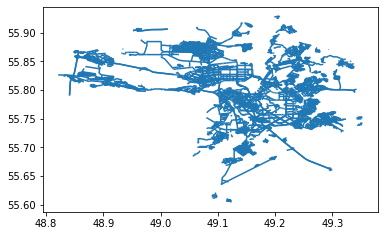

In [11]:
roads_gdf.plot()

# Point 3

In [12]:
with open('../scripts/bustime_parser/config.yaml') as f:
    CONFIG = yaml.load(f, Loader=yaml.FullLoader)

In [13]:
postgres_engine = create_engine('postgresql+psycopg2://{}:{}@{}/{}'.format(
    CONFIG["DB_USER"],
    CONFIG["DB_PASS"],
    CONFIG["DB_HOST"],
    CONFIG["DB_NAME"]
))

In [14]:
telemetry_sample = pd.read_sql("""
select t.*
from transport.telemetry t
    left join transport.routes r
        on t.bus_id = r.id
    left join transport.cities c
        on r.city_id = c.id
where True
    and date(timestamp) = '2021-11-01'
    and c.name = 'kazan'
""", postgres_engine)

In [15]:
telemetry_gdf = telemetry_sample.copy()
telemetry_gdf['geometry'] = gpd.GeoSeries.from_xy(x=telemetry_gdf['lon'], y=telemetry_gdf['lat'])
telemetry_gdf = gpd.GeoDataFrame(telemetry_gdf, geometry='geometry')

In [16]:
def clip_telemetry(telemetry_raw, stops_raw, roads_raw, buffer=50):
    """
    docstring
    """
    
    telemetry_gdf = telemetry_raw.set_crs(4326)
    stops_gdf = stops_raw.set_crs(4326)
    roads_gdf = roads_raw.set_crs(4326)
    
    epsg = 32600 + int(telemetry_gdf['lon'].mean() + 186)//6
    
    telemetry_gdf_utm = telemetry_gdf.to_crs(epsg)
    stops_gdf_utm = stops_gdf.to_crs(epsg)
    roads_gdf_utm = roads_gdf.to_crs(epsg)
    
    stops_buffer = stops_gdf_utm['geometry'].buffer(buffer).unary_union
    roads_buffer = roads_gdf_utm['geometry'].buffer(buffer).unary_union
    
    joined_buffer = gpd.GeoSeries([stops_buffer, roads_buffer]).unary_union
    
    stops_clipped = gpd.clip(telemetry_gdf_utm, joined_buffer)
    
    return stops_clipped

In [17]:
telemetry_clipped = clip_telemetry(telemetry_gdf, stops_gdf, roads_gdf, 50)

# Point 4

In [18]:
stops_utm_gdf = stops_gdf.set_crs(4326)
stops_utm_gdf = stops_utm_gdf.to_crs(32639)

In [19]:
def identify_stops(telemetry_raw, stops_raw, buffer=50, speed=15):
    for gdf in [telemetry_raw, stops_raw]:
        if gdf.crs is None or gdf.crs.name.find('UTM')==-1:
            raise Exception('Some df from args is not in projected CRS')
            
    telemetry_gdf = telemetry_raw.copy()
    stops_gdf = stops_raw.copy()
    
    sjoin = gpd.sjoin_nearest(telemetry_gdf,
                              stops_gdf,
                              how='left',
                              max_distance=buffer,
                              rsuffix='stop',
                              distance_col='dist')
    
    sjoin['is_stop'] = (sjoin['id'].notna())&(sjoin['speed']<=speed)
    
    return sjoin

In [20]:
telemetry_marked_gdf = identify_stops(telemetry_clipped, stops_utm_gdf, 50)

<AxesSubplot:>

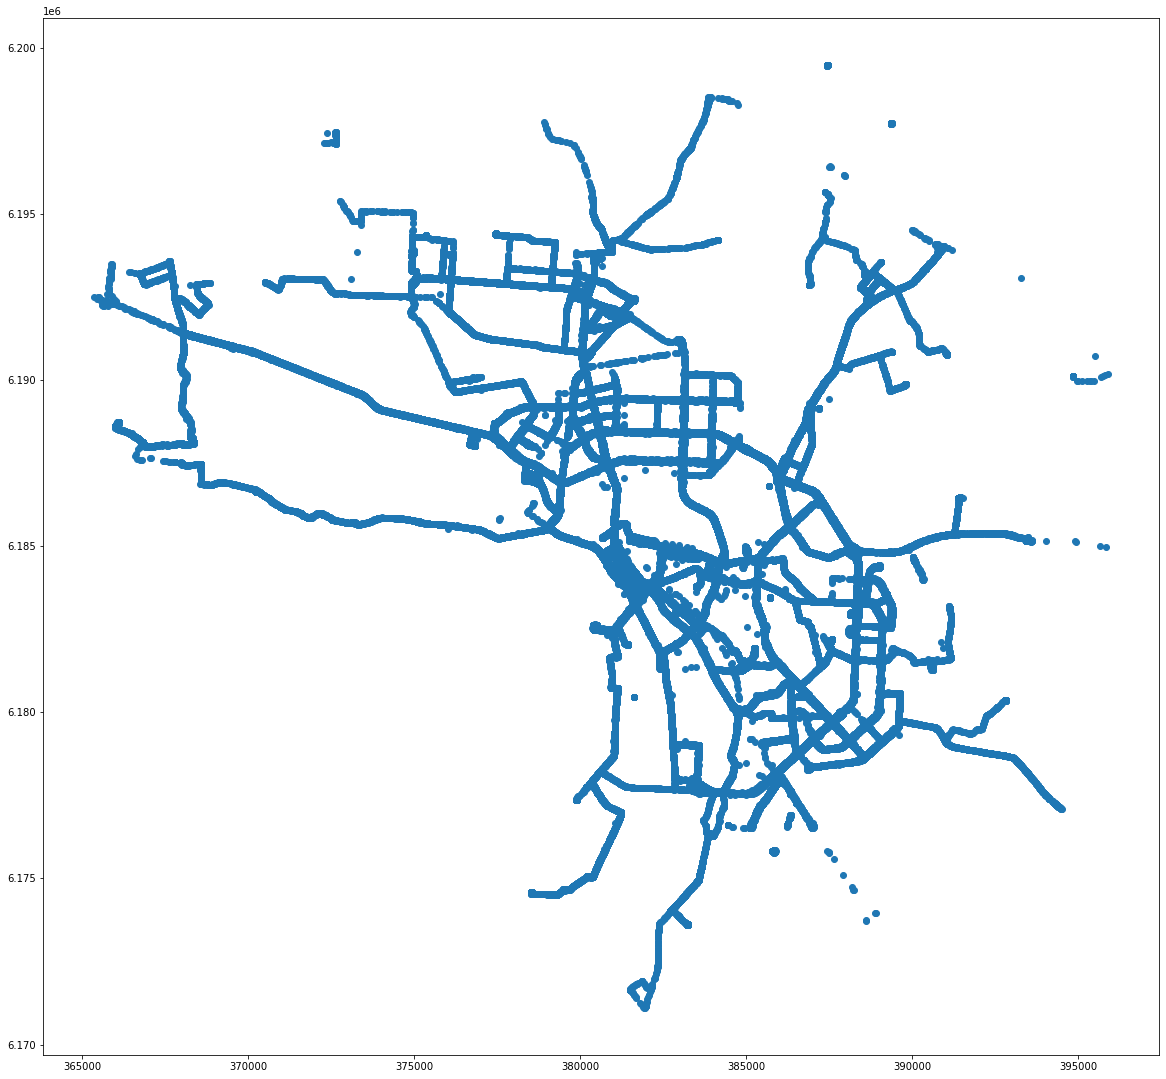

In [21]:
telemetry_marked_gdf.plot(figsize=(20,20))

<AxesSubplot:>

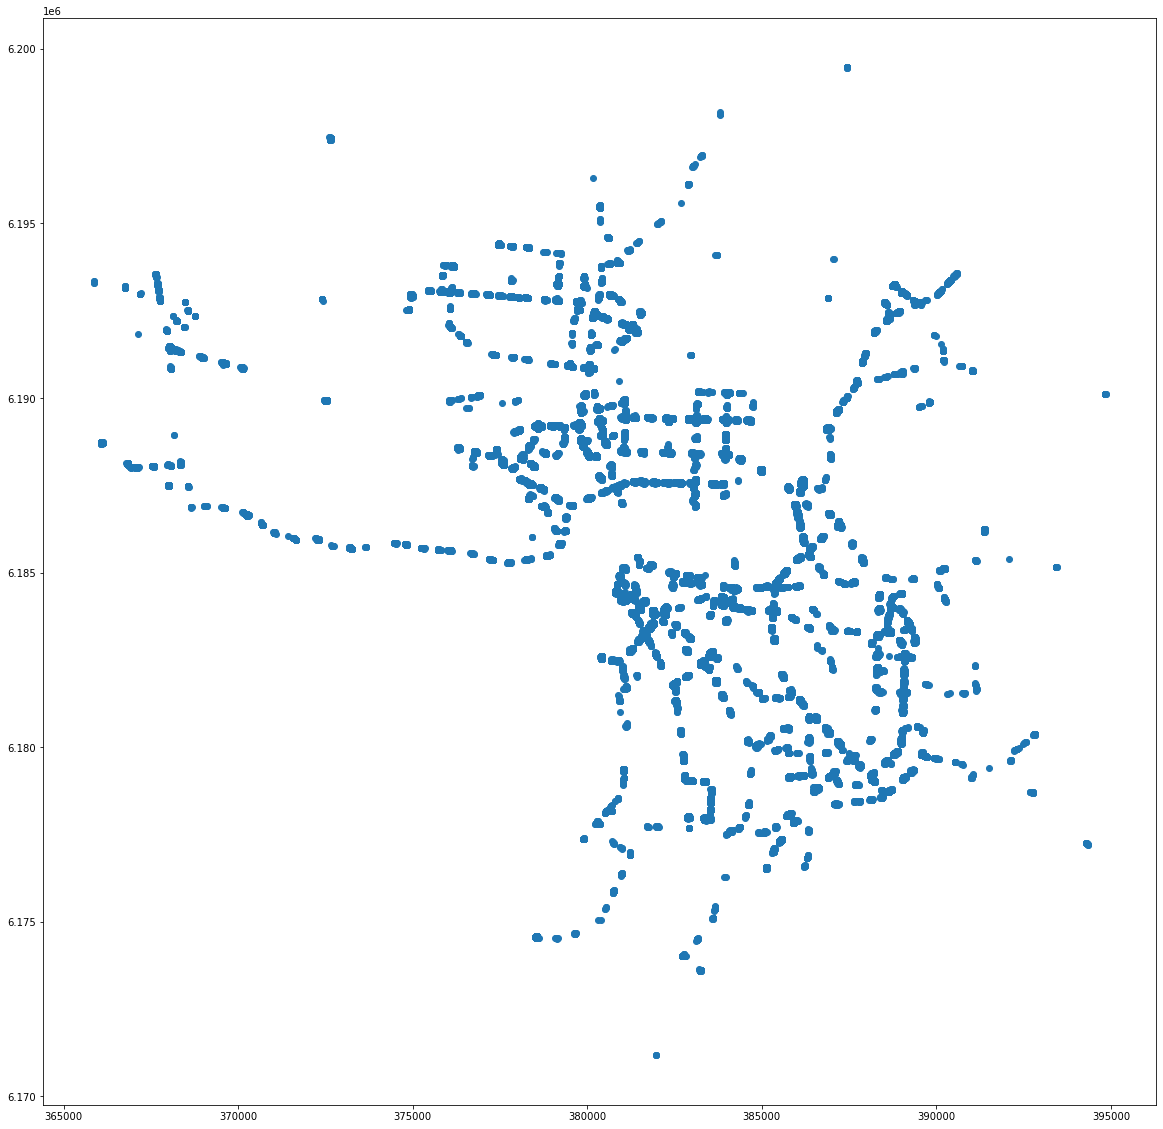

In [22]:
telemetry_marked_gdf[telemetry_marked_gdf['is_stop']].plot(figsize=(20,20))

In [23]:
telemetry_marked_gdf

,uniqueid,timestamp,bus_id,heading,speed,lon_left,lat_left,direction,gosnum,bortnum,...,upload_date,geometry,index_stop,type,id,lat_stop,lon_stop,name,dist,is_stop
328595,53432bb9,2021-11-01 11:52:02,999,151,60,49.199138,55.722755,0,АС389,12389,...,2021-11-04 18:15:22.971517,POINT (386888.261 6176692.742),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
327537,be8574c1,2021-11-01 10:03:00,999,150,46,49.199067,55.722833,0,А520РВ,12520,...,2021-11-04 18:15:22.971517,POINT (386884.028 6176701.537),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
328720,aa231866,2021-11-01 12:06:01,999,148,51,49.198922,55.722987,0,АС390,12390,...,2021-11-04 18:15:22.971517,POINT (386875.367 6176718.910),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
329970,53432bb9,2021-11-01 14:07:02,999,147,60,49.198550,55.723287,0,АС389,12389,...,2021-11-04 18:15:22.971517,POINT (386852.872 6176752.898),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
327980,73a26f5f,2021-11-01 10:49:00,999,326,59,49.198967,55.723367,0,А543РВ,12543,...,2021-11-04 18:15:22.971517,POINT (386879.292 6176761.120),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37210,ba2bfcf2,2021-11-01 11:36:58,965,272,31,49.053083,55.879001,0,Х251ХМ,4327,...,2021-11-04 18:14:11.439703,POINT (378204.621 6194326.217),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
36917,e0964784,2021-11-01 08:17:42,965,273,31,49.045803,55.879165,0,АС833,4140,...,2021-11-04 18:14:11.439703,POINT (377749.779 6194357.304),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
39889,d84d575c,2021-11-01 13:23:20,965,257,3,49.046562,55.879182,0,АС175,4166,...,2021-11-04 18:14:11.439703,POINT (377797.307 6194357.855),782.0,node,990914609.0,55.879181,49.046996,улица Дениса Давыдова,27.150841,True
36474,d84d575c,2021-11-01 07:46:36,965,273,32,49.045672,55.879179,0,АС175,4166,...,2021-11-04 18:14:11.439703,POINT (377741.629 6194359.093),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [40]:
def get_tracks(df_raw):
    """
    docstring
    """
    
    df = df_raw.copy()
    df = df.sort_values(['uniqueid', 'timestamp'])
    
    df['track'] = ((df['id']!=df['id'].shift(1))&\
                   (df['id'].shift(1).notna())|\
                   (df['uniqueid']!=df['uniqueid'].shift(1))).cumsum()
    
    return df.sort_values(['uniqueid', 'timestamp']).reset_index(drop=True)

In [41]:
tracks_gdf = get_tracks(telemetry_marked_gdf)

In [42]:
tracks_gdf.head(50)

,uniqueid,timestamp,bus_id,heading,speed,lon_left,lat_left,direction,gosnum,bortnum,...,geometry,index_stop,type,id,lat_stop,lon_stop,name,dist,is_stop,track
0,0031a60e,2021-11-01 06:14:40,968,195,31,49.042950,55.827733,0,АС163,4141,...,POINT (377409.488 6188639.477),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
1,0031a60e,2021-11-01 06:15:40,968,335,13,49.042767,55.825350,0,АС163,4141,...,POINT (377390.529 6188374.644),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
2,0031a60e,2021-11-01 06:16:40,968,343,0,49.042683,55.825533,0,АС163,4141,...,POINT (377385.844 6188395.155),681.0,node,992487230.0,55.825838,49.042519,Горьковское шоссе (улица Восстания),35.463021,True,1
3,0031a60e,2021-11-01 06:17:40,968,163,0,49.042667,55.825550,0,АС163,4141,...,POINT (377384.895 6188397.075),681.0,node,992487230.0,55.825838,49.042519,Горьковское шоссе (улица Восстания),33.364286,True,1
4,0031a60e,2021-11-01 06:18:40,968,167,0,49.042650,55.825567,0,АС163,4141,...,POINT (377383.884 6188398.997),681.0,node,992487230.0,55.825838,49.042519,Горьковское шоссе (улица Восстания),31.254902,True,1
5,0031a60e,2021-11-01 06:19:40,968,45,0,49.042650,55.825567,0,АС163,4141,...,POINT (377383.884 6188398.997),681.0,node,992487230.0,55.825838,49.042519,Горьковское шоссе (улица Восстания),31.254902,True,1
6,0031a60e,2021-11-01 06:20:40,968,325,0,49.042667,55.825550,0,АС163,4141,...,POINT (377384.895 6188397.075),681.0,node,992487230.0,55.825838,49.042519,Горьковское шоссе (улица Восстания),33.364286,True,1
7,0031a60e,2021-11-01 06:21:40,968,232,0,49.042667,55.825567,0,АС163,4141,...,POINT (377384.949 6188398.967),681.0,node,992487230.0,55.825838,49.042519,Горьковское шоссе (улица Восстания),31.550346,True,1
8,0031a60e,2021-11-01 06:22:40,968,52,0,49.042633,55.825567,0,АС163,4141,...,POINT (377382.819 6188399.027),681.0,node,992487230.0,55.825838,49.042519,Горьковское шоссе (улица Восстания),30.993271,True,1
9,0031a60e,2021-11-01 06:23:40,968,148,0,49.042633,55.825567,0,АС163,4141,...,POINT (377382.819 6188399.027),681.0,node,992487230.0,55.825838,49.042519,Горьковское шоссе (улица Восстания),30.993271,True,1


In [244]:
def aggregate_tracks(tracks_gdf_raw):
    """
    docstring
    """
    
    tracks_gdf = tracks_gdf_raw.copy()
    tracks_gdf['name'] = tracks_gdf['name'].astype(str)

    tracks_grouped = tracks_gdf.groupby(['track', 'uniqueid', 'bus_id']).agg({
        'speed': ['mean', 'median'],
        'timestamp': ['min', 'max'],
        'geometry': lambda x: list(x),
        'name': 'max',
        'dist': 'min',
        'id': 'max'
    }).reset_index()

    level_one = tracks_grouped.columns.get_level_values(0).astype(str)
    level_two = tracks_grouped.columns.get_level_values(1).astype(str)
    tracks_grouped.columns = level_one + '_' + level_two
    
    tracks_grouped = tracks_grouped.rename(columns={
        'track_': 'track',
        'uniqueid_': 'uniqueid',
        'bus_id_': 'bus_id',
        'geometry_<lambda>': 'points',
        'name_max': 'name_to',
        'dist_min': 'dist',
        'id_max': 'id_to'
    })
    
    tracks_grouped['id_from'] = tracks_grouped['id_to'].shift(1)
    tracks_grouped['uniqueid_from'] = tracks_grouped['uniqueid'].shift(1)
    
    tracks_grouped['id_from'] = tracks_grouped['id_from'].where(tracks_grouped['uniqueid']==\
                                                                tracks_grouped['uniqueid_from'], None)
    
    tracks_grouped['time_travelled'] = (tracks_grouped['timestamp_max'] - tracks_grouped['timestamp_min']).dt.seconds

    tracks_grouped = tracks_grouped[[
        'uniqueid',
        'bus_id',
        'speed_mean',
        'speed_median',
        'timestamp_min',
        'timestamp_max',
        'id_from',
        'id_to',
        'time_travelled'
    ]]
    
    tracks_grouped['id_from'] = tracks_grouped['id_from'].astype(pd.Int64Dtype())
    tracks_grouped['id_to'] = tracks_grouped['id_to'].astype(pd.Int64Dtype())
    
    return tracks_grouped

In [245]:
aggregated_tracks_raw = aggregate_tracks(tracks_gdf)

In [246]:
aggregated_tracks_raw.head()

,uniqueid,bus_id,speed_mean,speed_median,timestamp_min,timestamp_max,id_from,id_to,time_travelled
0,0031a60e,968,1.073171,0.0,2021-11-01 06:14:40,2021-11-01 06:54:40,<NA>,992487230,2400
1,0031a60e,968,0.000000,0.0,2021-11-01 06:55:40,2021-11-01 06:55:40,992487230,992487242,0
2,0031a60e,968,23.000000,23.0,2021-11-01 06:56:40,2021-11-01 06:57:40,992487242,992487238,60
3,0031a60e,968,24.000000,24.0,2021-11-01 06:58:40,2021-11-01 06:59:40,992487238,992487207,60
4,0031a60e,968,27.000000,27.0,2021-11-01 07:00:40,2021-11-01 07:01:40,992487207,994382499,60


# Point 5

In [248]:
aggregated_tracks = aggregated_tracks_raw.copy()

<AxesSubplot:>

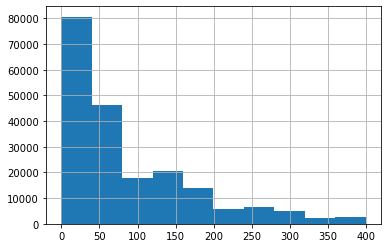

In [249]:
aggregated_tracks[(aggregated_tracks['time_travelled']<400)]['time_travelled'].hist()

In [250]:
aggregated_tracks['time_travelled'].value_counts(normalize=True).sort_index()

0        0.356050
1        0.000014
2        0.000005
3        0.000014
4        0.000019
           ...   
22096    0.000005
22411    0.000005
23411    0.000005
23702    0.000005
35773    0.000005
Name: time_travelled, Length: 2122, dtype: float64

In [251]:
aggregated_tracks['time_travelled'].quantile(0.98)

613.0

In [252]:
aggregated_tracks.head()

,uniqueid,bus_id,speed_mean,speed_median,timestamp_min,timestamp_max,id_from,id_to,time_travelled
0,0031a60e,968,1.073171,0.0,2021-11-01 06:14:40,2021-11-01 06:54:40,<NA>,992487230,2400
1,0031a60e,968,0.000000,0.0,2021-11-01 06:55:40,2021-11-01 06:55:40,992487230,992487242,0
2,0031a60e,968,23.000000,23.0,2021-11-01 06:56:40,2021-11-01 06:57:40,992487242,992487238,60
3,0031a60e,968,24.000000,24.0,2021-11-01 06:58:40,2021-11-01 06:59:40,992487238,992487207,60
4,0031a60e,968,27.000000,27.0,2021-11-01 07:00:40,2021-11-01 07:01:40,992487207,994382499,60


In [258]:
len(aggregated_tracks)

211091

## Notes
36% of null values, but 98% quantile is fairly low (10 minutes)

# Point 6
Not neccessary yet